# Logistic Regression and Optimization

In this notebook we will implement a linear classifier and train it using stochastic gradient descent. We need just NumPy and Matplotlib.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Two-dimensional classification

Let's solve a 2D classification problem. We will use simple data created specifically for our purposes.

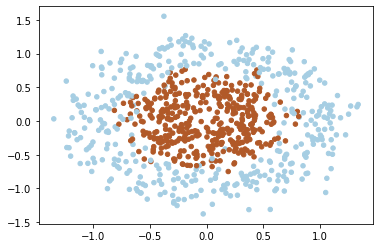

In [2]:
with open('train_data.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target_data.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

In [3]:
# # alternatively, you can generate synthetic/fake datasets using scikit-learn 
# from sklearn.datasets import make_circles, make_moons
# # generate 2d classification dataset
# # X, y = make_circles(800,noise=0.18, factor=0.4, random_state=1)
# X, y = make_moons(n_samples=600, noise=0.25)

# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
# plt.show()

In [4]:
# np.save('target1',y)
# np.save('train1',X)

## Adding Features

As you can notice the data above isn't linearly separable and the decision line between two classes is circular. A simple trick (not always working) is to embed the points in some higher-dimensional space and exploit a particular function to "raise" or "lower" some points, hoping to obtain a linearly separable problem. The idea under this displayed on image below:

![](kernel.png)

Separation of points can be accomplished by adding the square value of the data points as a new feature. This feature would have been more effective if all the points of one of the two classes had been centered at the origin.

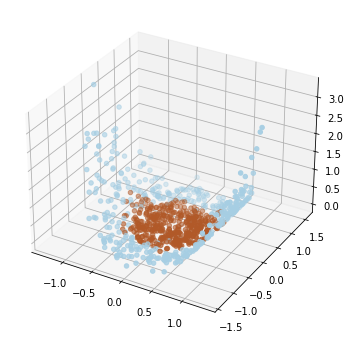

In [5]:
# uncomment the following line to rotate frame
# %matplotlib notebook

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

X2 = np.zeros((X.shape[0], 3))
for r in range(X.shape[0]):
    X2[r,:] = np.insert(X[r,:], 2, [X[r,0]**4])

ax.scatter(X2[:,0], X2[:,1], X2[:,2], c=y, cmap=plt.cm.Paired)
plt.show()

In [6]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))
    for r in range(X.shape[0]):
        X_expanded[r,:] = np.insert(X[r,:], 2, [X[r,0]*X[r,0], X[r,1]*X[r,1], X[r,0]*X[r,1], 1])
    
    return X_expanded

In [7]:
X_expanded = expand(X)

Here are some tests for your implementation of `expand` function.

In [8]:
test_X = np.array([
        [0,0],
        [1,0],
        [2.06,-1.18],
        [-0.65,2.2]
    ])

# call your expand function
test_expanded = expand(test_X)

# the 6 feature columns:   x0       x1       x0^2     x1^2     x0*x1    1
test_expanded

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
       [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
       [ 2.06  , -1.18  ,  4.2436,  1.3924, -2.4308,  1.    ],
       [-0.65  ,  2.2   ,  0.4225,  4.84  , -1.43  ,  1.    ]])

## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = w \cdot x = \begin{pmatrix} w_1 & w_2 & \cdots & w_n \end{pmatrix} \begin{pmatrix} x_1\\ x_2 \\ \vdots \\ x_n \end{pmatrix}  $$
$$ \mathrm{P}( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + e^{-a}} = \sigma(a)$$


In [9]:
def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,6] (expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """

    return 1/(1+np.exp(-np.dot(X,w)))

In [10]:
dummy_weights = np.linspace(-1.5, 1.5, 6)
probability(X_expanded[:1, :], dummy_weights)[0]

0.28057690234079113

In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

Loss for one sample $(x_i,y_i)$: $$ l(x_i, y_i, w) = - \left[ {y_i \cdot \log \mathrm{P}(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot \log (1-\mathrm{P}(y_i = 1\, | \, x_i,w))}\right] $$

Loss for many samples: $$ L(X, y, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$



In [11]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute scalar loss function L using formula above.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    
    p = probability(X, w)
    
    return -1/X.shape[0] * np.sum(y * np.log(p) + (1-y) * np.log(1-p))

In [12]:
compute_loss(X_expanded, y, dummy_weights)

1.020998052168053

Since we train our model with gradient descent, we should compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 

Let $\mathrm{P} = \mathrm{P}( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + e^{-wx}}$. Then the single sample derivative is

$$ \frac{\partial}{\partial w} \left[-y \log\mathrm{P} - (1 - y) \log\left(1 - \mathrm{P} \right) \right] =\\  -y \frac{\partial}{\partial w} \log \mathrm{P} - (1 - y) \frac{\partial}{\partial w}\log\left(1 - \mathrm{P}\right) =\\ xy\,\frac{-1}{\exp(wx) +1} + (1-y)x\, \frac{\exp(wx)}{\exp(wx) + 1} = \\ xy\,( \mathrm{P} - 1) + (1-y)x\,  \mathrm{P} =\\ x (\mathrm{P} - y)$$

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how $L$ changes if you shift $w$ by $10^{-5}$ or so).

In [13]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    
    p = probability(X, w)
    
    return 1/X.shape[0] * np.dot(X.T, p-y)

In [14]:
np.linalg.norm(compute_grad(X_expanded, y, dummy_weights))

0.38370992422206673

Here's an auxiliary function that visualizes the predictions:

In [15]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

## Mini-batch SGD

Stochastic gradient descent just takes a random batch of $m$ samples on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$



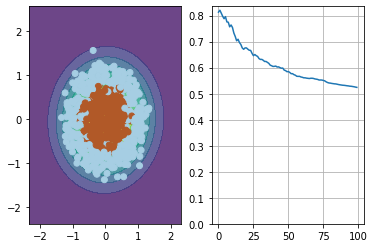

<Figure size 432x288 with 0 Axes>

In [16]:
# np.random.seed(42)

# weights
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.1 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # Keep in mind that compute_grad already does averaging over batch for you!
    w = w - eta * compute_grad(X_expanded[ind,:], y[ind], w)
visualize(X, y, w, loss)
plt.clf()

In [17]:
compute_loss(X_expanded, y, w)

0.5232772295460835